In [2]:
#Ensure you pip install
#TODO: N-grams 
#Stop word removal and tokenization
#Add any extra text cleaning wanted
#Save to the CSV when all checked so that people can do work in other files
#Currently only works with the cleaned dataset. Lots more work needed for other one
#Get rid of other languages

import pandas as pd
import numpy as np 
import re

pd.set_option('display.max_colwidth', None)

#Replace with your own path
f = open("Data/HateSpeechDataset.csv",'r')
r_cols = ['tweet', 'hate', 'nums']
tweets = pd.read_csv(f, sep=',', names=r_cols)
tweets = tweets[1:]

In [3]:
word_dict = dict()
word_counter = 0

#This is only in english, not sure how many languages are in there...
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
              "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", 
              "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", 
              "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", 
              "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
              "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", 
              "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
              "against", "between", "into", "through", "during", "before", "after", 
              "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", 
              "under", "again", "further", "then", "once", "here", "there", "when", "where", 
              "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", 
              "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", 
              "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [4]:
counter2 = [0,0,0,0,0,0]
nGrams = [dict(),dict(),dict(),dict(),dict(),dict()]

In [5]:
#Removes urls
def clean_text(text):
    clean_tweet = text + " "
    clean_tweet = re.sub(" http| https", "", clean_tweet)

    clean_tweet = re.sub("hyper text transfer protocol", "", clean_tweet)

    clean_tweet = re.sub("www .* com ", "", clean_tweet)
    clean_tweet = re.sub("www .* org ", "", clean_tweet)
    clean_tweet = re.sub("www .* net ", "", clean_tweet)
    clean_tweet = re.sub("www .* uk ", "", clean_tweet)

    clean_tweet = re.sub(" $", "", clean_tweet)
    return clean_tweet

In [6]:
#Tokenization and numbering
def number_words(text):
    global word_dict
    global word_counter
    new_numbers = []
    for i in text:
        if i in word_dict:
            new_numbers.append(word_dict[i])
        else:
            word_dict[i] = word_counter
            word_counter = word_counter + 1
            new_numbers.append(word_dict[i])
    return new_numbers

#Stop word removal
def stop_word_removal(text):
    return_text = []
    global stop_words
    for i in range(len(text)):
        if not text[i] in stop_words:
            return_text.append(text[i])
            
    return return_text

#N-gram creation
def nGrammify(text_nums, n):
    global nGrams
    global counter2
    myList = []
    for i in range(len(text_nums)-n+1):
        nums = ""
        for j in range(n):
            nums = nums + "^" + str(text_nums[i+j])
        if nums in nGrams[n-1]:
            myList.append(nGrams[n-1][nums])
        else:
            nGrams[n-1][nums] = counter2[n-1]
            counter2[n-1] = counter2[n-1]+1
            myList.append(nGrams[n-1][nums])
    return myList

In [7]:

tweets['tweet'] = tweets['tweet'].apply(clean_text)
tweets['splits'] = tweets['tweet'].str.split()
tweets['newNum'] = tweets['splits'].apply(number_words)
tweets['noStop'] = tweets['splits'].apply(stop_word_removal)
tweets['2_grams'] = tweets['newNum'].apply(lambda x: nGrammify(x, 2))

In [8]:
#We should only run this line once are done with everything we want to do
tweets['hate'] = pd.to_numeric(tweets['hate'], errors='coerce')
tweets = tweets.dropna(subset=['hate'])
tweets.to_csv("finished_hate_speech.csv")

In [9]:
#Going to make figures based on n-grams and word counts next...
#Make sure to pip install matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(style="darkgrid")

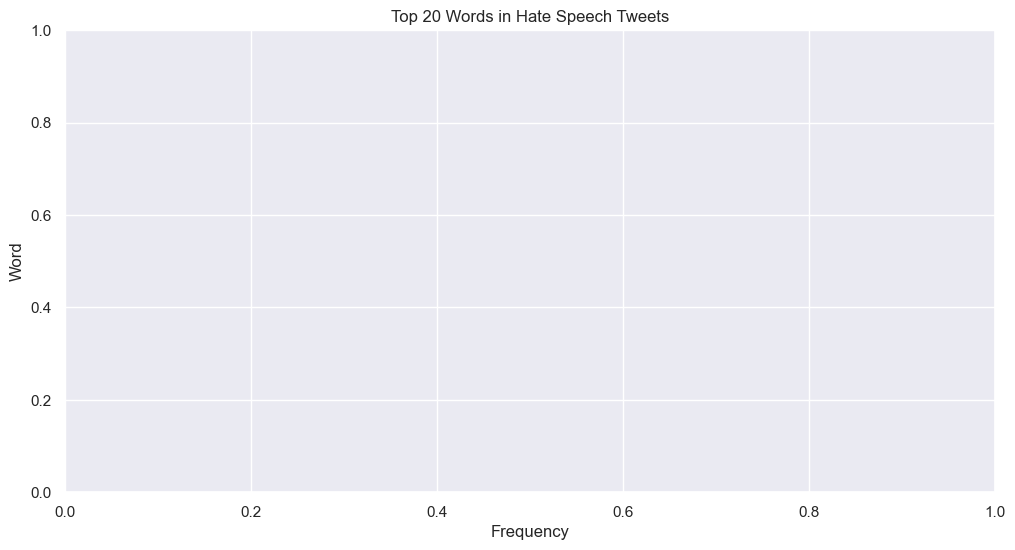

In [10]:
# Filter tweets labeled as hate speech
hate_tweets = tweets[tweets['hate'] == "1"]

# Flatten all words from noStop column of hate tweets
all_hate_words = [word for sublist in hate_tweets['noStop'] for word in sublist]

# Count frequency
hate_word_counts = Counter(all_hate_words)

# Get top 20 most common words
top_hate_words = dict(hate_word_counts.most_common(20))

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(top_hate_words.values()), y=list(top_hate_words.keys()))
plt.title("Top 20 Words in Hate Speech Tweets")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

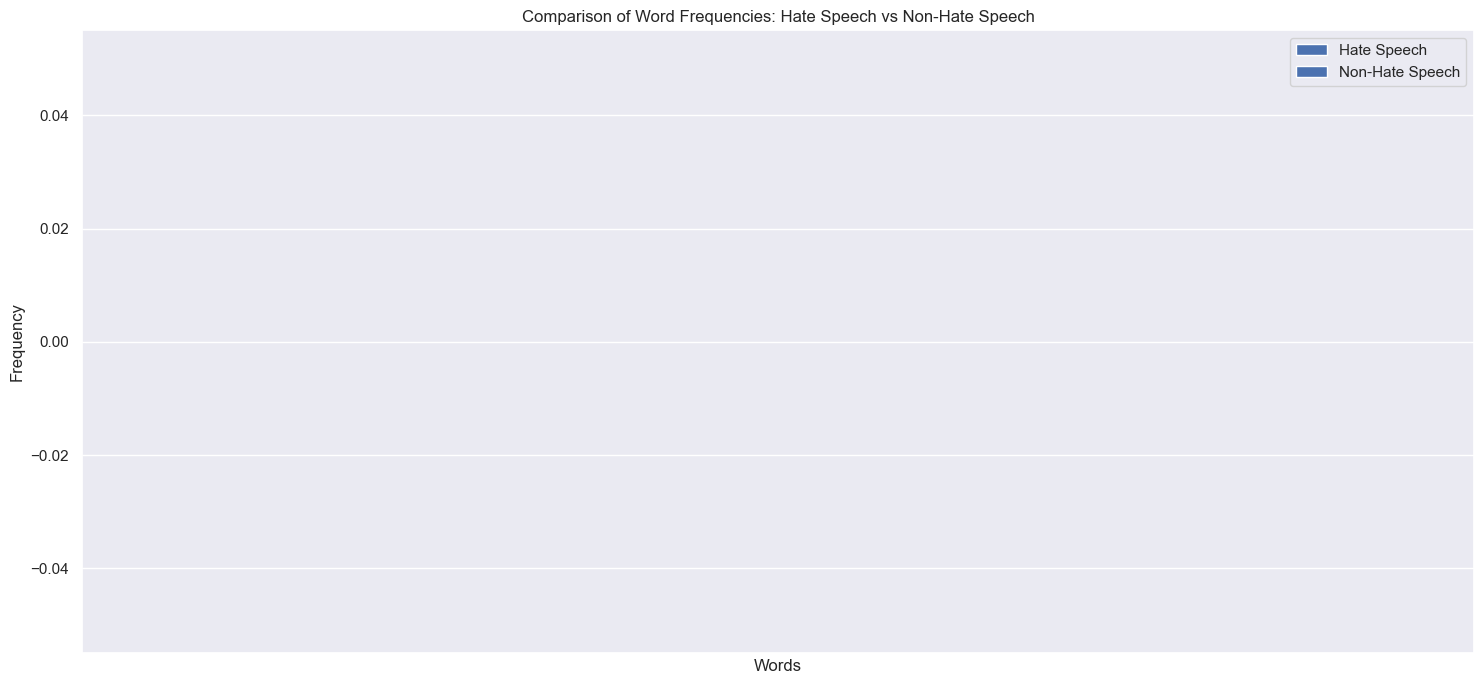

In [11]:
#Word frequency figure side by side bar chart

# Separate hate and non-hate tweets
hate_tweets = tweets[tweets['hate'] == "1"]
non_hate_tweets = tweets[tweets['hate'] == "0"]

hate_words = [word for sublist in hate_tweets['noStop'] for word in sublist]
non_hate_words = [word for sublist in non_hate_tweets['noStop'] for word in sublist]

# Count frequency for each category
hate_counts = Counter(hate_words)
non_hate_counts = Counter(non_hate_words)

# Get top 15 words from each
top_hate = [word for word, count in hate_counts.most_common(15)]
top_non_hate = [word for word, count in non_hate_counts.most_common(15)]

# Union top words for both categories so we can compare
all_top_words = list(set(top_hate + top_non_hate))

# get frequencies for all top words
hate_freqs = [hate_counts.get(word, 0) for word in all_top_words]
non_hate_freqs = [non_hate_counts.get(word, 0) for word in all_top_words]

# Plot side by side so we can compare
x = np.arange(len(all_top_words))
width = 0.4

plt.figure(figsize=(15,7))
plt.bar(x - width/2, hate_freqs, width, label='Hate Speech', color='red')
plt.bar(x + width/2, non_hate_freqs, width, label='Non-Hate Speech', color='green')
plt.xticks(x, all_top_words, rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Comparison of Word Frequencies: Hate Speech vs Non-Hate Speech")
plt.legend()
plt.tight_layout()
plt.show()

['what a', 'a slut', 'of the', 'it is', 'i am', 'in the', 'do not', 'if you', 'you are', 'i have', 'to the', 'on the', 'the article', 'to be', 'is a', 'is not', 'you have', 'does not', 'that is', 'i do']


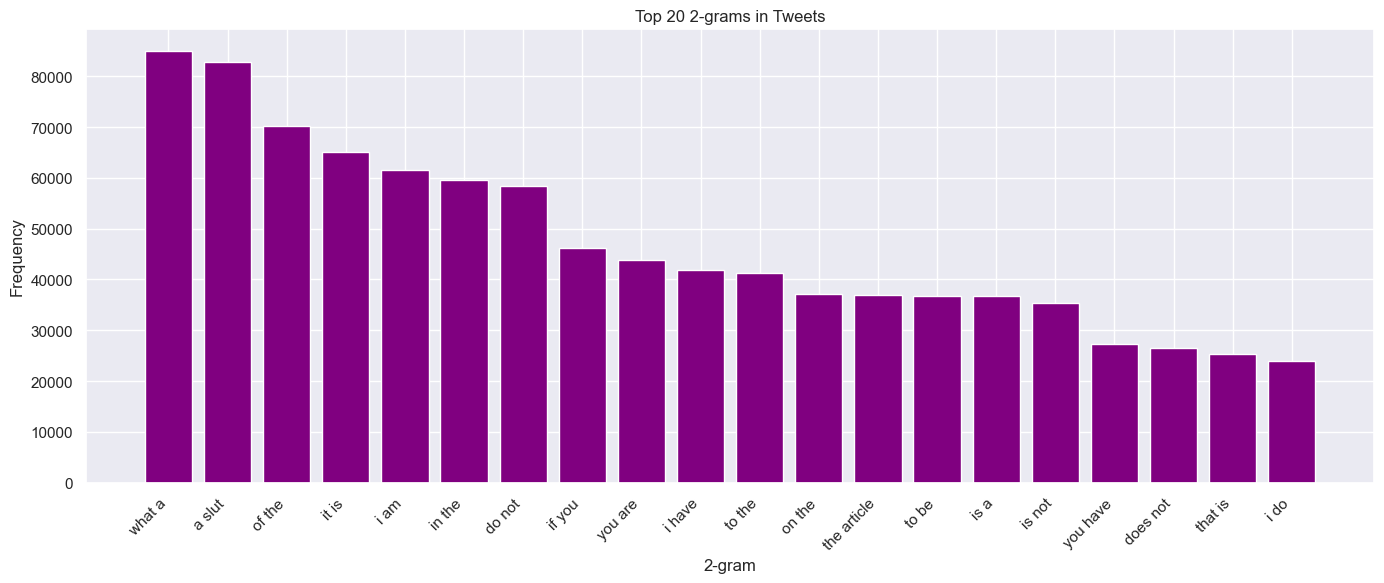

In [12]:
#2 gram frequency figure with stop words
reverse_2gram = {v: k for k, v in nGrams[1].items()}

all_2grams_ids = [ng_id for sublist in tweets['2_grams'] for ng_id in sublist]

ngram_counts = Counter(all_2grams_ids)

top_20 = ngram_counts.most_common(20)

# Prepare readable labels and counts
labels = []
counts = []

for ng_id, count in top_20:
    ng_string = reverse_2gram[ng_id]
    
    word_ids = [int(x) for x in ng_string.split("^")[1:]]  # skip empty first element
    
    # Map IDs to words
    words = [key for wid in word_ids for key, val in word_dict.items() if val == wid]
    
    labels.append(" ".join(words))  # Join words for axis label
    counts.append(count)

print(labels)

plt.figure(figsize=(14,6))
plt.bar(range(len(top_20)), counts, color='purple')
plt.xticks(range(len(top_20)), labels, rotation=45, ha='right')
plt.title("Top 20 2-grams in Tweets")
plt.xlabel("2-gram")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



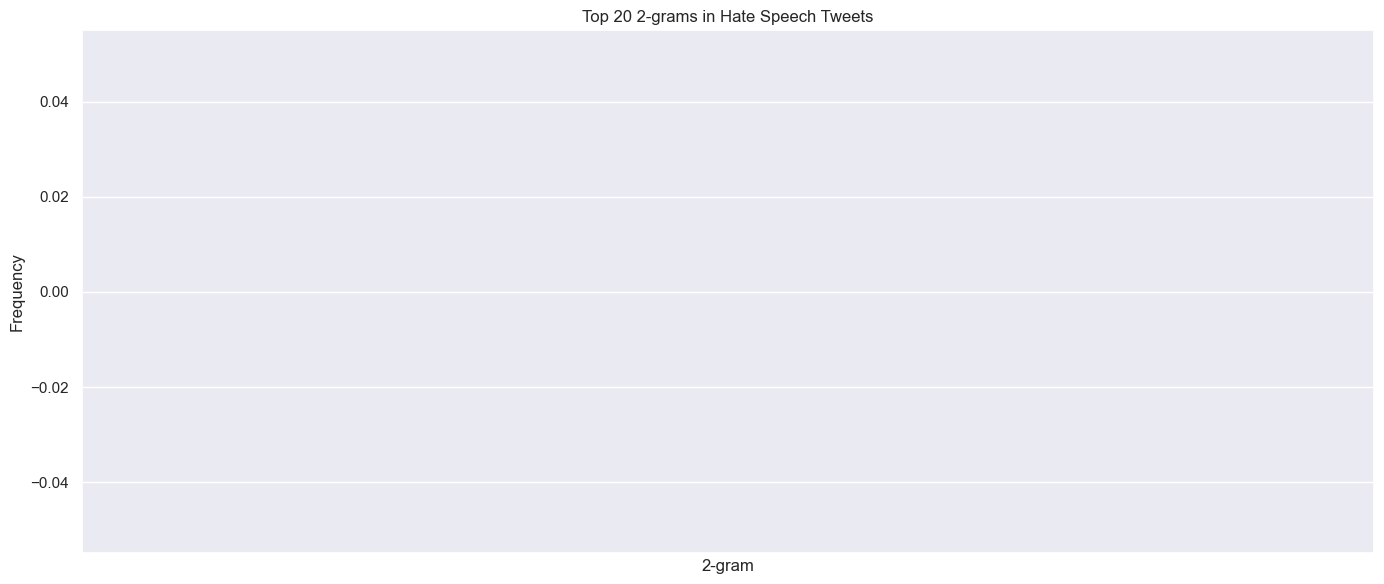

In [13]:
# N grams figure without stop words and only in hate speech tweets
# Filter hate speech tweets 
hate_tweets = tweets[tweets['hate'] == "1"]

def generate_ngrams(words, n=2):
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

hate_tweets['2grams_noStop'] = hate_tweets['noStop'].apply(lambda x: generate_ngrams(x, n=2))

all_2grams_hate = [ng for sublist in hate_tweets['2grams_noStop'] for ng in sublist]

ngram_counts_hate = Counter(all_2grams_hate)

top_20_hate_ngrams = dict(ngram_counts_hate.most_common(20))

plt.figure(figsize=(14,6))
plt.bar(range(len(top_20_hate_ngrams)), top_20_hate_ngrams.values(), color='red') 
plt.xticks(range(len(top_20_hate_ngrams)), top_20_hate_ngrams.keys(), rotation=45, ha='right')
plt.title("Top 20 2-grams in Hate Speech Tweets")
plt.xlabel("2-gram")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [45]:

from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
# Combine newNum and 2_grams for model input
tweets['tokens'] = tweets.apply(
    lambda row: [str(x) for x in row['newNum'] + row['2_grams']],
    axis=1
)

In [38]:
#Split data into training and testing sets
X = ["".join(tokens) for tokens in tweets['tokens']]
y = tweets['hate'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

In [39]:
for i, tokens in enumerate(tweets['tokens']):
    for t in tokens:
        try:
            int(t)
        except:
            print(f"Row {i} token '{t}' cannot be converted to int")

In [40]:
#Convert to a sparse matrix
def id_sparse_matrix(X):
    rows = []
    cols = []
    tweets = []
    for tweet_id, tweet in enumerate(X):
        for wid in word_ids:
            rows.append(tweet_id)
            cols.append(int(wid))
            tweets.append(1)
    return csr_matrix((tweets, (rows, cols)), shape=(len(X), max(cols)+1))

X_train_matrix = id_sparse_matrix(X_train)
X_test_matrix = id_sparse_matrix(X_test)

clf = MultinomialNB()
clf.fit(X_train_matrix, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Naive Bayes Model Evaluation:
Accuracy: 0.819694564149089
Precision: 0.0
Recall: 0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


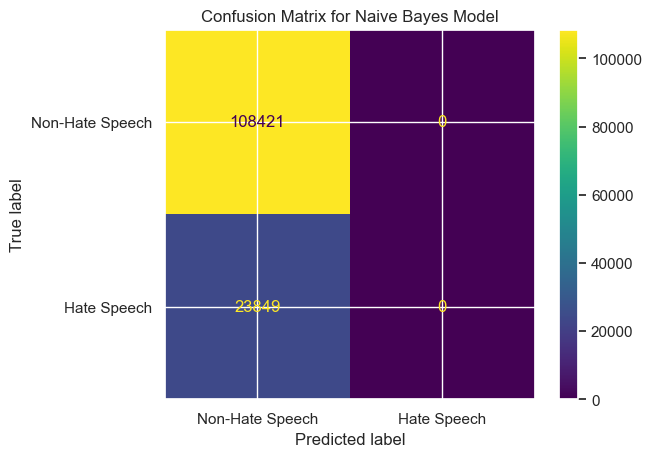

In [41]:
#Evaluate the model
predictions = clf.predict(X_test_matrix)

labels = ['Non-Hate Speech', 'Hate Speech']
cm = metrics.confusion_matrix(y_test, predictions)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

print("Naive Bayes Model Evaluation:")
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))

display.plot()
plt.title("Confusion Matrix for Naive Bayes Model")
plt.show()

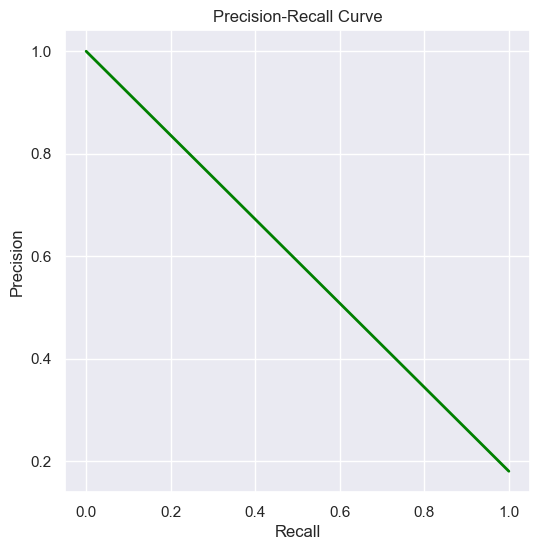

In [49]:
probs = clf.predict_proba(X_test_matrix)
precision, recall, thresholds = precision_recall_curve(y_test, probs[:, 1])

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [50]:
print("Classification Report:",classification_report(y_test, predictions, target_names=labels))

Classification Report:                  precision    recall  f1-score   support

Non-Hate Speech       0.82      1.00      0.90    108421
    Hate Speech       0.00      0.00      0.00     23849

       accuracy                           0.82    132270
      macro avg       0.41      0.50      0.45    132270
   weighted avg       0.67      0.82      0.74    132270



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
